# `Setup`

In [9]:
# Library Import
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageSequence
import os
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
from utils.helpers import *

# NN Library Import
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image

# Printing current working directory
print(os.getcwd())

/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu


In [10]:
# Metal Acceleration
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### `Config`

In [11]:
# Loading Config File
config = load_config()

# Extracting training images path
train_img = config['dataset']['images']['train']

In [12]:
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'}}

## `Custom Pytorch Dataset`

Below is our custom Pytorch dataset object, which will be passed to downstream dataloaders. The dataset will also be fetchable from the utils/StatefarmPytorchDataset.py file

In [13]:
# Custom PyTorch Dataset Class
class StateFarmDataset(Dataset):
    def __init__(self, config, transform=None, target_transform=None):
        """
        Custom PyTorch Dataset Class.
        Args:
            config (dict): configuration dictionary. Loaded using load_config() function from utils/helpers.py
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional transform to be applied on a label.
        """
        
        # Ensuring directory corresponds to root of repo
        while not os.getcwd().split('/')[-1] == 'aml_itu':
            os.chdir('../')

        # Generating data variables
        self.metadata = pd.read_csv(config['dataset']['data'])
        self.id_to_class = config['dataset']['class_mapping']
        self.metadata['target'] = self.metadata['classname'].map(self.id_to_class)
        self.img_dir = config['dataset']['images']['train']
        self.metadata['img_path'] = self.img_dir + '/' + self.metadata['classname'] + '/' + self.metadata['img']
        self.img_labels = self.metadata[['img', 'classname', 'img_path']]
        
        # Data transformations
        self.transform = transform
        self.target_transform = target_transform

    # Returns length of dataset
    def __len__(self):
        return len(self.img_labels)

    # Returns image and label
    def __getitem__(self, idx):
        """
        Function for returning image and label.
        Args:
            idx (int): index of the sample to return.
        """
        
        # Extract image path
        img_path = self.img_labels.iloc[idx, 2]
        # Read image
        image = read_image(img_path)
        # Extract label
        label = self.img_labels.iloc[idx, 1]
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    
    def display_classes(self, 
                        seed:int = None, 
                        transform = None, 
                        id_to_class:bool = False,
                        figsize:tuple =(15, 10)):
        """Function for displaying randomg samples from each class"""
        
        # Set seed if specified
        if seed: np.random.seed(seed)
        
        # Extract random image per class
        self.imgs = self.img_labels.groupby('classname').sample(1).reset_index(drop=True)
        
        # Generate figure
        fig, axes = plt.subplots(3, 3, figsize=figsize)
        
        # Loop through axes and display images
        for i, ax in enumerate(axes.flat):
            img = Image.open(self.imgs.iloc[i, 2])
            ax.imshow(img)
            if id_to_class: ax.set_title(self.id_to_class[self.imgs.iloc[i, 1]])
            else: ax.set_title(self.imgs.iloc[i, 1])
            
            ax.axis('off')
        # Apply tight layout
        fig.tight_layout()


In [14]:
data = StateFarmDataset(config)

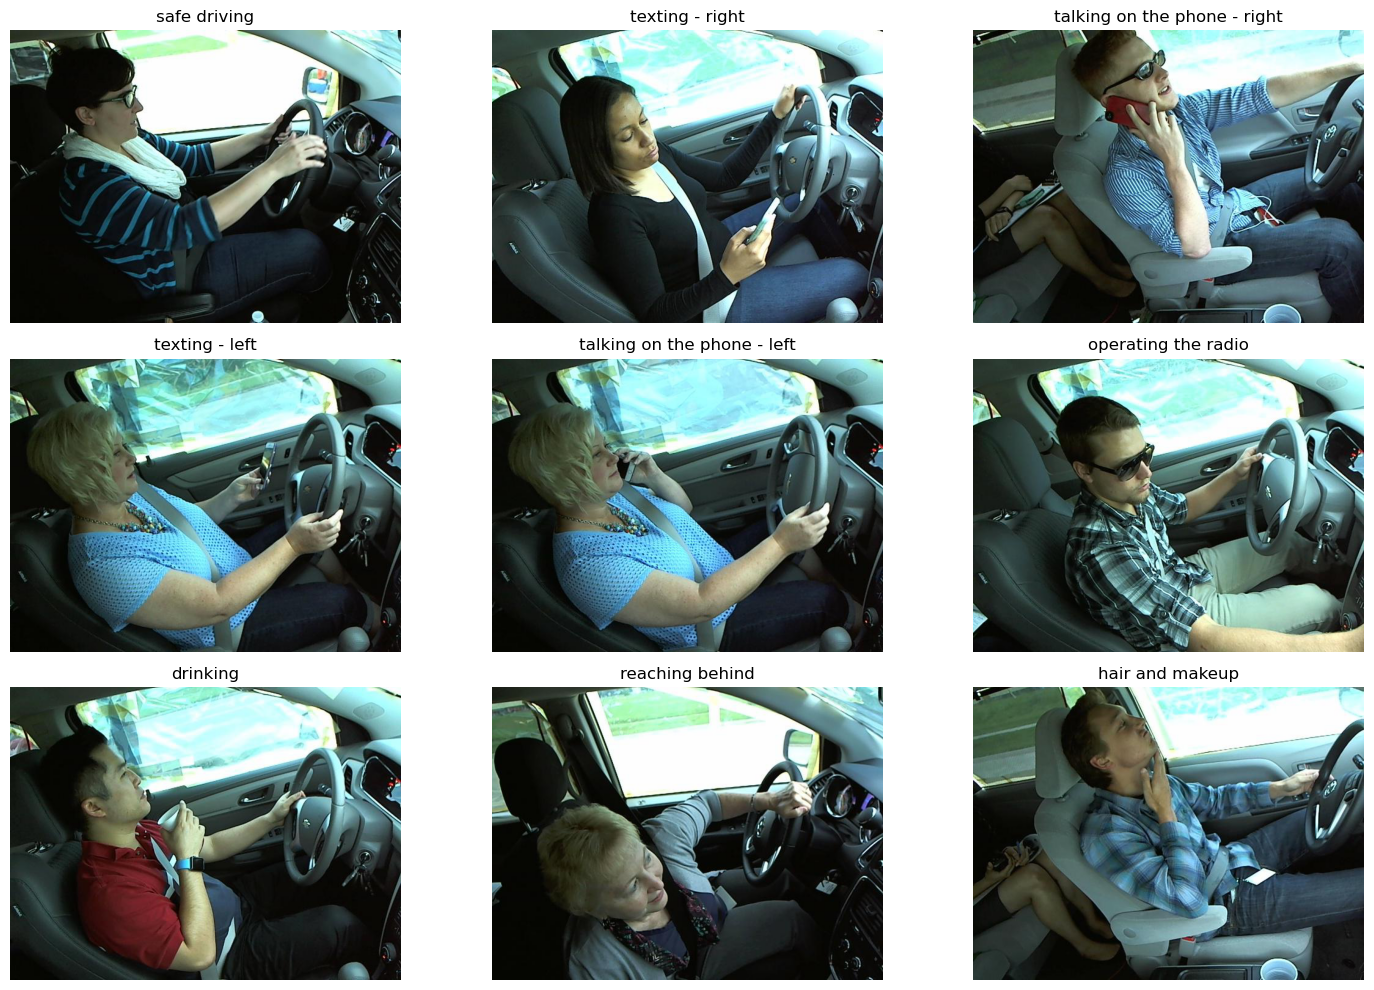

In [15]:
data.display_classes(id_to_class=True)

In [17]:
data.metadata

,subject,classname,img,target,img_path
0,p002,c0,img_44733.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
1,p002,c0,img_72999.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
2,p002,c0,img_25094.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
3,p002,c0,img_69092.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
4,p002,c0,img_92629.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
...,...,...,...,...,...
22419,p081,c9,img_56936.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22420,p081,c9,img_46218.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22421,p081,c9,img_25946.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22422,p081,c9,img_67850.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...


In [6]:
from utils.StatefarmPytorchDataset import StateFarmDataset
data0 = StateFarmDataset(config)

In [8]:
data0.metadata

,subject,classname,img,target,img_path
0,p002,c0,img_44733.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
1,p002,c0,img_72999.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
2,p002,c0,img_25094.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
3,p002,c0,img_69092.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
4,p002,c0,img_92629.jpg,safe driving,../state-farm-distracted-driver-detection/imgs...
...,...,...,...,...,...
22419,p081,c9,img_56936.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22420,p081,c9,img_46218.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22421,p081,c9,img_25946.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
22422,p081,c9,img_67850.jpg,talking to passenger,../state-farm-distracted-driver-detection/imgs...
